In [4]:
!pip install tensorflow --quiet
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
ticker = "ICICIBANK.NS"

print(f"Downloading intraday data for {ticker} ...")

data = yf.download(
    ticker,
    period="5d",      # last 5 trading days
    interval="5m",    # 5-minute candles
    auto_adjust=False
)

data = data.dropna()
print("Shape:", data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

Shape: (375, 6)


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ICICIBANK.NS,ICICIBANK.NS,ICICIBANK.NS,ICICIBANK.NS,ICICIBANK.NS,ICICIBANK.NS
Datetime,,,,,,
2025-12-01 03:45:00+00:00,1390.599976,1390.599976,1393.900024,1389.000000,1393.900024,0
2025-12-01 03:50:00+00:00,1391.400024,1391.400024,1391.800049,1389.000000,1390.599976,128382
2025-12-01 03:55:00+00:00,1392.800049,1392.800049,1393.800049,1390.199951,1391.300049,71554
2025-12-01 04:00:00+00:00,1395.199951,1395.199951,1395.699951,1392.500000,1392.500000,149976
2025-12-01 04:05:00+00:00,1396.000000,1396.000000,1396.000000,1394.199951,1395.300049,144338


In [7]:
# Mid-price approximation and microstructure features
data["mid_price"] = (data["High"] + data["Low"]) / 2
data["spread"] = data["High"] - data["Low"]
data["returns"] = data["mid_price"].pct_change()

# Label: 1 if next mid_price is higher, else 0
data["future_mid"] = data["mid_price"].shift(-1)
data["label"] = (data["future_mid"] > data["mid_price"]).astype(int)

data = data.dropna()

print(data[["mid_price", "spread", "returns", "label"]].head())
print("\nLabel distribution:\n", data["label"].value_counts())

Price                        mid_price    spread   returns label
Ticker                                                          
Datetime                                                        
2025-12-01 03:50:00+00:00  1390.400024  2.800049 -0.000755     1
2025-12-01 03:55:00+00:00  1392.000000  3.600098  0.001151     1
2025-12-01 04:00:00+00:00  1394.099976  3.199951  0.001509     1
2025-12-01 04:05:00+00:00  1395.099976  1.800049  0.000717     0
2025-12-01 04:10:00+00:00  1394.450012  3.700073 -0.000466     0

Label distribution:
 label
1    188
0    185
Name: count, dtype: int64


In [8]:
features = ["mid_price", "spread", "returns"]

X = data[features].values
y = data["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

seq_len = 20  # how many past steps the model sees

X_seq = []
y_seq = []

for i in range(len(X_scaled) - seq_len):
    X_seq.append(X_scaled[i:i+seq_len])
    y_seq.append(y[i+seq_len])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (353, 20, 3)
y_seq shape: (353,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq,
    test_size=0.2,
    shuffle=False    # keep time order
)

X_train.shape, X_test.shape

((282, 20, 3), (71, 20, 3))

In [10]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

C:\Users\Rugved\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5780 - loss: 0.6700 - val_accuracy: 0.6197 - val_loss: 0.6691
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6064 - loss: 0.6632 - val_accuracy: 0.6056 - val_loss: 0.6656
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6064 - loss: 0.6605 - val_accuracy: 0.6197 - val_loss: 0.6644
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6135 - loss: 0.6594 - val_accuracy: 0.6197 - val_loss: 0.6628
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6277 - loss: 0.6510 - val_accuracy: 0.6338 - val_loss: 0.6608
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6489 - loss: 0.6524 - val_accuracy: 0.6338 - val_loss: 0.6563
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6418 - loss: 0.6480 - val_accuracy: 0.6197 - val_loss: 0.6661
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6418 - loss: 0.6475 - val_accuracy: 0.6338 - val_loss: 0.6622


Test Accuracy: 0.606


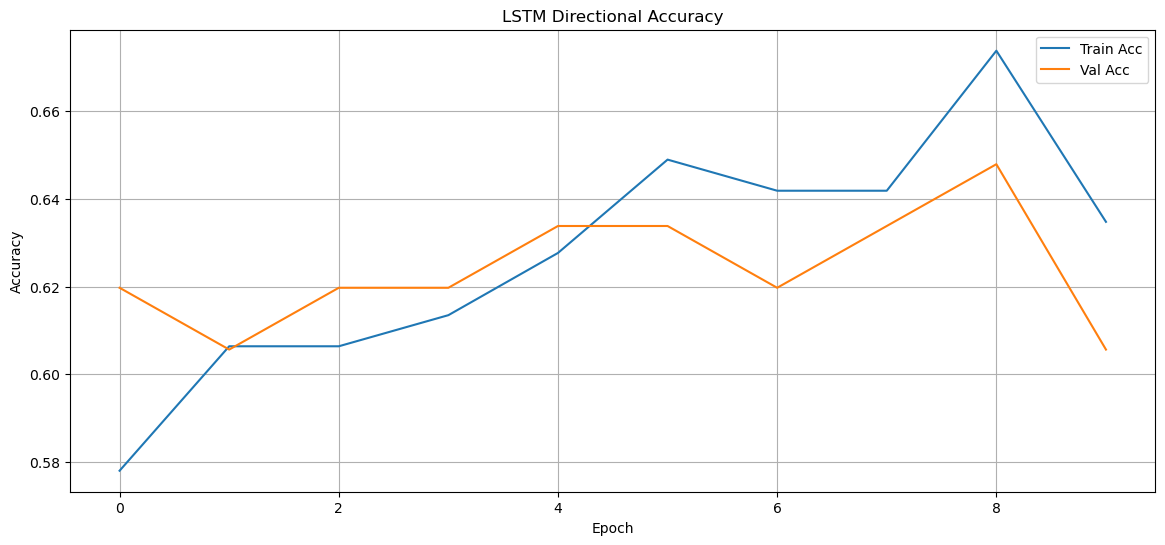

In [13]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.3f}")

plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("LSTM Directional Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()